# P2: Project Results (Sigma Squad)

* [1. Analysis of the Final Merged Dataset](##1.-analysis-of-the-final-merged-data-set)
* [2. Movie Success Index](##2-movie-success-index)
* [3. Actor Success Index](##3-actor-success-index)
* [4. Completion and Cleaning of Actor Data](##4-completion-and-cleaning-of-actor-data)

## 1. Analysis of the Final Merged Dataset:

After loading and merging our 3 datasets, we obtained the final raw dataset (`final_merged_data.csv`). It's composition can be seen below.

In [1]:
from src.data import raw_data

raw_df = raw_data()
raw_df.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Review score,Movie votes,Movie director,Movie star,Movie budget,Movie gross,Movie company,Number of nomination,Nomination winner
0,/m/03vyhn,ghosts_of_mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",4.9,52000.0,John Carpenter,Natasha Henstridge,28000000.0,14010832.0,Screen Gems,NaN,NaN
1,/m/08yl5d,getting_away_with_murder:_the_jonbenét_ramsey_...,2000,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"Mystery, Biographical film, Drama, Crime Drama",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/m/0crgdbh,brun_bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}",Norway,"Crime Fiction, Drama",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/m/0285_cd,white_of_the_eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",United Kingdom,"Thriller, Erotic thriller, Psychological thriller",6.2,2200.0,Donald Cammell,David Keith,NaN,NaN,Mrs. White's Productions,NaN,NaN
4,/m/01mrr1,a_woman_in_flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}",Germany,Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In order to proceed with our analysis, we need to deal with the NaN values.  

### The bar plot below shows how many movies have valid values in categories, that are important for our further computations.

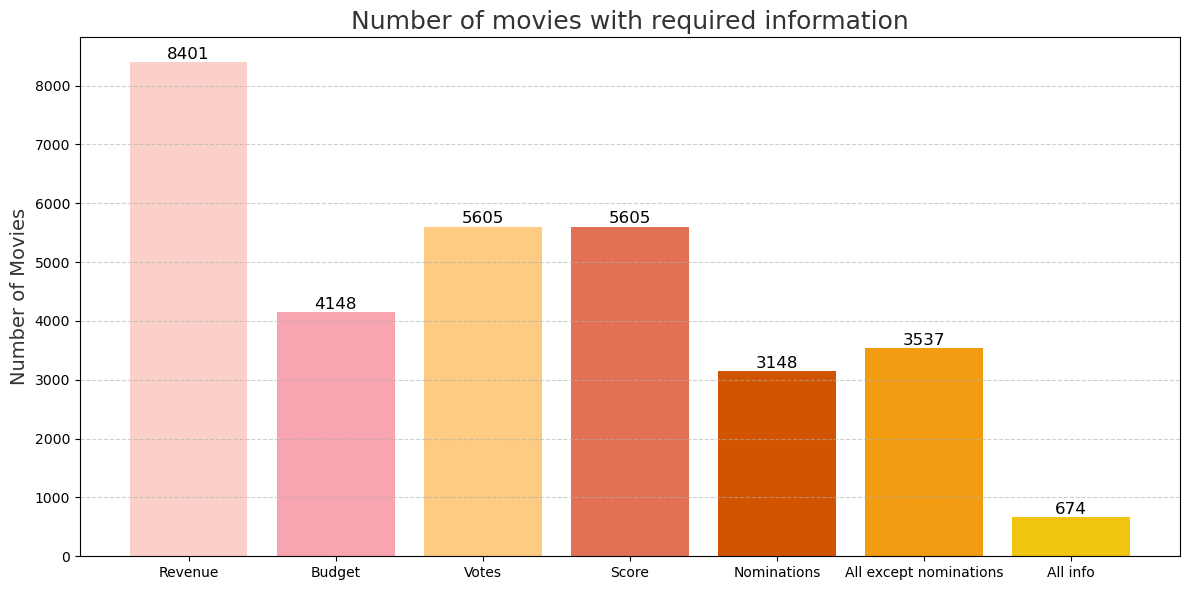

In [2]:
from src.utils import bar_plot_available_data

bar_plot_available_data(raw_df)

To establish the movie success index, we are focused on specific criteria such as budget, revenues, ratings, number of Oscar nominations, and the movie profitability. Our goal is to assess whether we have enough reliable data to effectively study these factors.  

We analyzed the available data and observed that the original CMU Movie dataset contains 8 401 movies with revenue data. From the additional datasets, we identified movies that meet other key criteria, including budget (4 148 movies) and review score (5 605 movies).  

### Finally, we have 3 537 movies that have all required information combined. 

In [3]:
from src.data import clean_data

df = clean_data(raw_df)
print(f'The length of the working dataset of movies that have all required informations is {len(df)}.')

The length of the working dataset of movies that have all required informations is 3537.


Given this sample size, we are confident that we have sufficient and reliable data to move forward with constructing the success index. The next step will be to normalize and properly weight each criterion to build the success index.

## 2. Movie Success Index:

To create our success index, we evaluated movie success based on four key factors: **profitability**, **revenue**, **reviews**, and **Oscar nominations**. Both profitability and revenue were scaled using min-max normalization, providing a consistent framework to evaluate and compare success across variables with different ranges. 

After calculating the factors, we combined them into a final index. Profitability, revenue, and review factors are weighted (35%, 35%, and 30%, respectively) and adjusted by the Oscar factor. The resulting index is normalized again to a 0-10 scale, offering a single score representing each movie’s overall success.

Here is a more detailed explanation of the setup of each factor. Note that all functions used can be found in the `src/movie_success_model.py` file.

- **Profitability factor:** this factor measures how much revenue a movie generates relative to its budget. First, the profitability ratio (revenue divided by budget) is calculated. To reduce the impact of outliers, a logarithmic transformation (log) is applied, which compresses large values and accentuates smaller ones. The result is normalized to a 0-10 scale, making comparisons across movies straightforward.

- **Revenue factor:** this factor focuses solely on the movie's box office revenue. A log10 transformation is applied to balance the range of high and low revenues, particularly since box office numbers can vary greatly. After applying the transformation, scores are scaled from 0 to 10 for consistency.

- **Review factor:** this factor is directly taking the ImdB movie ratings which were already on a scale from 0 to 10.

- **Oscar multiplication factor:** this factor amplifies the success index based on Oscar nominations, recognizing industry recognition as a mark of success. The function uses a logarithmic transformation for diminishing returns, giving a smaller increase for each additional nomination, then scales by a multiplier to ensure consistent weighting.

### Below you can find histograms for each factor, showing the final distribution after applying our adjustments.

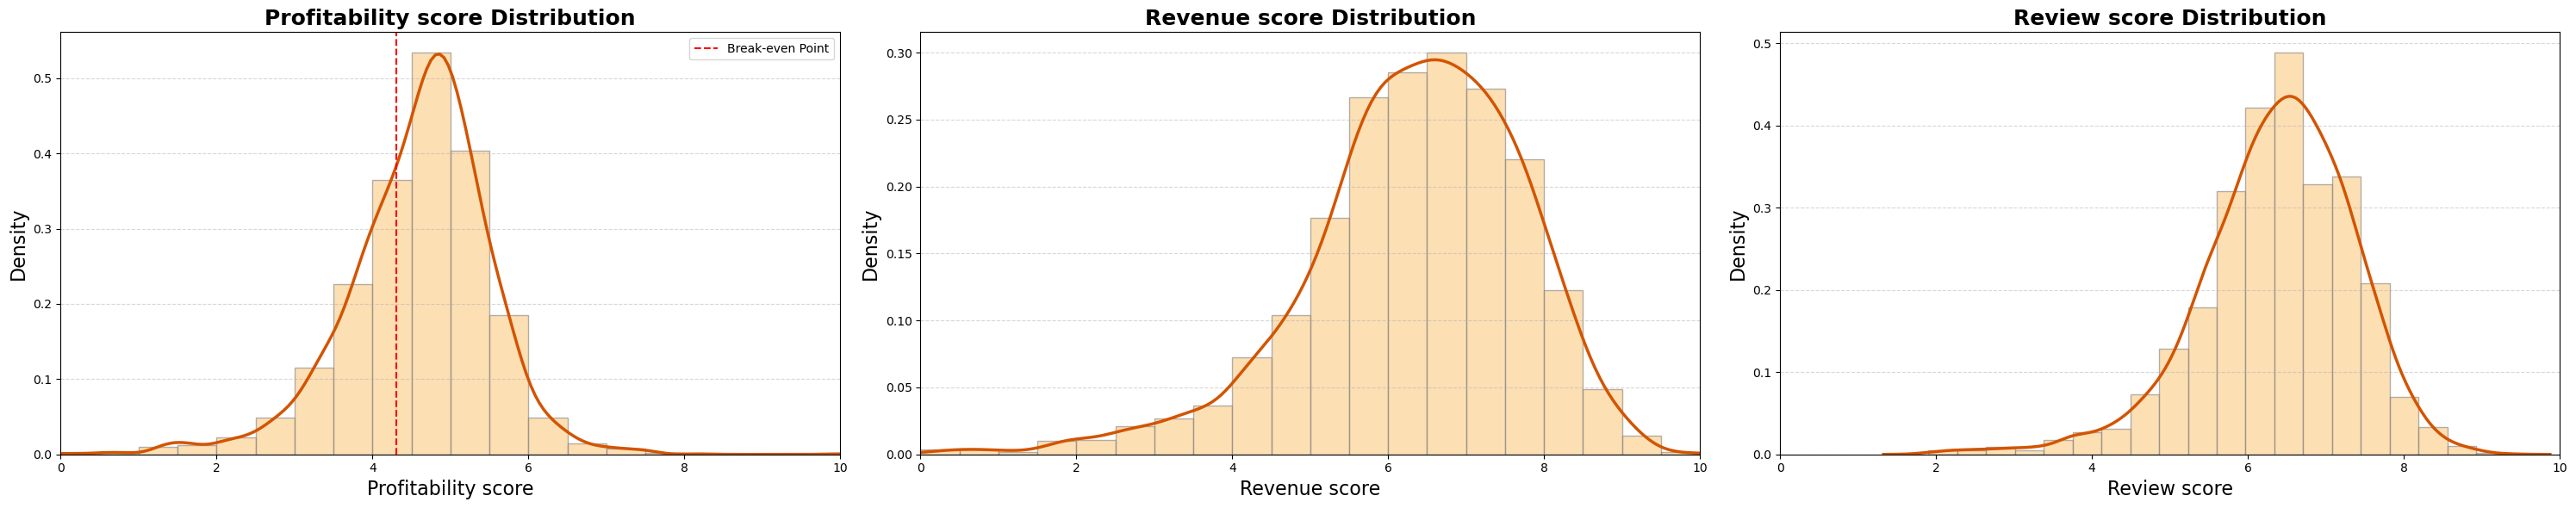

In [4]:
from src.utils import hist_std_config_ax, plt
from src.models import movie_success_index

movie_success_index(df)

fig, axes = plt.subplots(1, 3, figsize=(30, 6))  
hist_std_config_ax(df, 'Profitability score', axes[0])
hist_std_config_ax(df, 'Revenue score', axes[1])
hist_std_config_ax(df, 'Review score', axes[2])

plt.tight_layout()
plt.show()

### Oscar nomination distribution across movies.

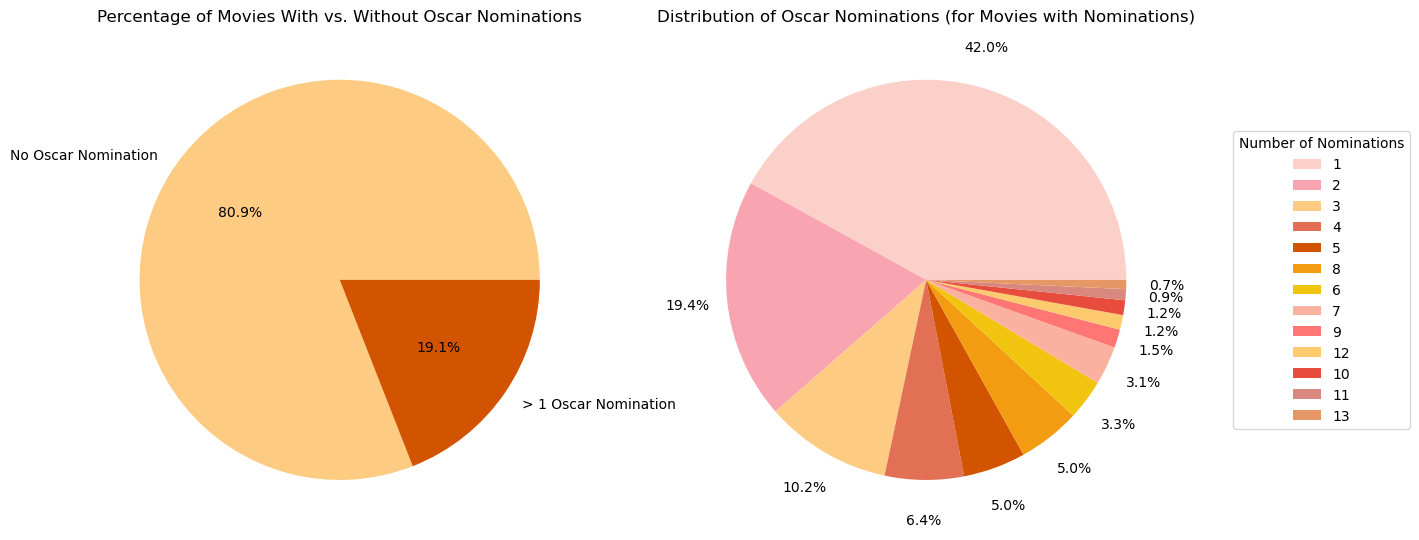

In [5]:
from src.utils import oscar_pie_chart

oscar_pie_chart(df)

On the left pie, we can see that only 19.1% of our analyzed movies have any Oscar nomination. Thus, we decided to create a multiplication factor, that will be multiplied with the final movie success index. Movies that have Oscar nominations will benefit from that multiplication factor, but the other movies won't be penalized. Moreover, the more nominations, the higher the multiplication factor.

### ***Example of ranking based on our movie success index :*** top 5 best and worst movies

In [6]:
from src.utils import top5_best, top5_worst

top5_best(df)

,Movie name,Movie release date,Movie Success Index,Review score,Revenue score,Profitability score
80920,the_lord_of_the_rings:_the_return_of_the_king,2003,7.916470,8.9,9.257307,5.999965
79973,the_lord_of_the_rings:_the_fellowship_of_the_ring,2001,7.850975,8.8,9.052642,5.835857
65287,forrest_gump,1994,7.844366,8.8,8.846968,6.022649
57552,e.t._the_extra-terrestrial,1982,7.818620,7.8,8.975484,7.262251
23702,avatar,2009,7.734081,7.8,10.000000,5.989874


In [7]:
top5_worst(df)

,Movie name,Movie release date,Movie Success Index,Review score,Revenue score,Profitability score
8416,deadfall,1993,1.034197,4.0,0.264990,0.000000
19093,dangerous_game,1993,1.524680,5.6,0.471943,0.173344
10467,wicked_stepmother,1989,1.735934,4.3,0.973217,1.540833
76763,the_specials,2000,1.770565,5.8,0.000000,1.352018
58128,best_laid_plans,1999,1.780705,6.1,0.603631,0.527457


## 3. Actor Success Index:

### Idea of the index

Now that we have established our movie success index we can move on to creating an actor success index. The goal is to be able to quantitatively compare the success of an actor and their career given the success of their movies. The main challenge here is finding a meaningful way to do so. To illustrate, our initial attempts at building the index relied on a mean of scores over an actors career. However, with this method, the most successful actors where side characters that starred in only one or two movies, but that happened to be huge successes. The index therefore needs to account not only for the absolute success of the movies but also for the amount of quality movies and the consistency of success.

### Main character bonus

The first thing we do when establishing the score is identifying main characters. Being chosen for the most prominent role of a movie is a certificate of trust from the production company. This is why we boost the movie score in which an actor is the star by 25% before processing it further. This is a way to account for desirability in the movie industry.

### Multiplier & Streak

To build the actor score, we have come up with a multiplier and streak system. For every actor, the movies are sorted by release date in ascending order. From the score of every movie, a multiplier is generated. If the score is within 25% of the last movie or better, the multiplier is generated proportionaly from the movie score (it is greater than 1, see code for the formula). If the score of the movie happens to be more than 25% worse than the last, the multiplier is generated proportionally to the percent difference between both successive movies (multiplier smaller than 1). This way, successive successful movies grow the cumulative multiplier, whilst inconsistencies and drops in quality decrease it. This systems values an actors ability to be consistent in the quality of their work. Moreover, repeatedly getting casted is an indicator for industry desirability. This means the system allows us to better capture the value an actor has had over their career.

### Final grade

 The product of all multipliers up to the current one (cumulative multiplier) is applied to the current movie score and the product is added to an array. This array therefore holds all movie scores of an actor, scalled by their respective cumulative multiplier. The array is then summed and a log10 is applied to the sum. The results are normalized using min-max normalization to obtain a comparable grade out of 10. 

### Below you may find plots for the distribution of the actor scores and a table for the most and least successful actors acording to our ranking

In [8]:
from src.models import actor_success_index
from src.data import actor_data

actor_df = actor_data(df)
actor_df = actor_success_index(actor_df)
actor_df.to_csv('data/actor_data.csv')

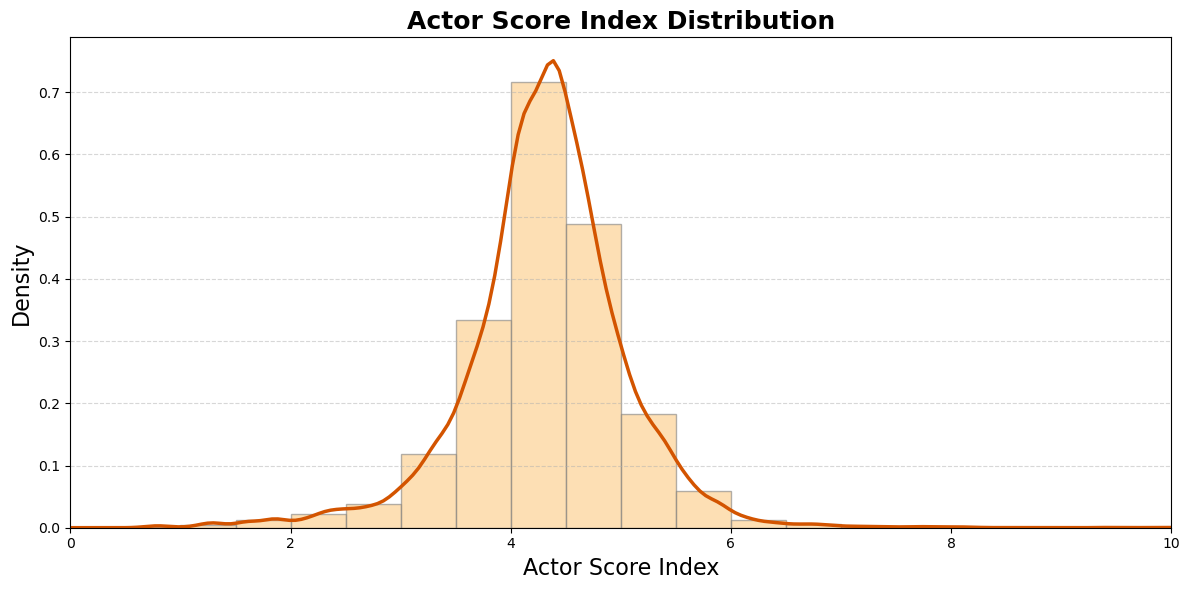

In [9]:
from src.utils import hist_std_config

hist_std_config(actor_df, 'Actor Score Index')

In [10]:
actor_df['Actor Score Index']

Actor name
denzel_washington      10.000000
matt_damon              9.912690
tom_hanks               9.741555
eddie_murphy            9.415060
tom_cruise              9.362255
                         ...    
j._kenneth_campbell     0.714754
evelyn_keyes            0.700949
james_dixon             0.700949
reilly_murphy           0.251820
peter_fonda             0.000000
Name: Actor Score Index, Length: 20693, dtype: float64

Notice how the results from the model somewhat align with our expectations, but also bring about interesting results: why is Peter Fonda so low on the score index? Inspection of the data shows a strong drop in movie quality at the end of his career which was picked up on by the multiplier & streak model. 

The above scores and rankings give us confidence in the quality of our preliminary analysis.

## 4. Completion and Cleaning of Actor Data

justifiy why only keep actors with height data